In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.patches import Patch
import itertools
from collections import deque

In [2]:

cpd_test = pd.read_csv('test50.csv', sep=',',low_memory=False)
cpd_train = pd.read_csv('train50.csv', sep=',',low_memory=False)
cpd_train.reset_index(drop=True, inplace=True)
cpd_test.reset_index(drop=True, inplace=True)
full_cpd = pd.concat([cpd_test, cpd_train], axis=1)
full_cpd = full_cpd[~full_cpd.index.duplicated()]

In [ ]:
y = pd.read_csv('upenn_test.tsv', sep='\t',low_memory=False)
y=y.rename(columns={"AF": "FAF", 'CIViC Evidence Level' : 'Civic_Evidence', 'DOMAIN' : 'Domain'})
q = y[['CHROM', 'POS', 'REF', 'ALT', 'REPORTED', 'SAMPLE', 'PCHANGE', 'GENE', 'Domain', 'ClinicalSignificance','EFFECT', 'Civic_Evidence', 'CATEGORIZATION', 'FAF', 'GNOMAD_AC', 'GNOMAD_AF', 'EXON_Rank', 'COSMIC_CNT','MVP_score', 'Civic_Drug', 'PMID_COUNT', 'KEGG']]
q = q[pd.to_numeric(q['FAF'], errors='coerce').notnull()]
q = q.loc[q['CATEGORIZATION'] != 'Tox']
q = q.loc[q['CATEGORIZATION'] != 'Artifact']
q['FAF'] = q['FAF'].astype(float)
q['PMID_COUNT'] = q['PMID_COUNT'].astype(float)
pd.set_option('display.max_columns', None)
q.head()

In [5]:
def pre_model(x):
    df = x.drop('CATEGORIZATION', axis=1)
    df = df.drop('SAMPLE', axis=1)
    df = df.drop('CHROM', axis=1)
    df = df.drop('POS', axis=1)
    df = df.drop('REF', axis=1)
    df = df.drop('ALT', axis=1)
    df = df.drop('REPORTED', axis=1)
    df.fillna(-999, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return(df)

In [6]:
#returns prediction in tuple(0) and probablities in tuple(1)
def getpreds(data,model,name):
    predl = model.predict(data=data)
    pred = [item[0] for item in predl]
    probl = model.predict_proba(X=data)
    prob = [item[0] for item in probl]
    df = pd.DataFrame({(name + '_pred'):pred, (name +'_prob'):prob})
    return (df)

In [8]:
compM = CatBoostClassifier()
compM.load_model('azurify.json', format='json')

In [9]:
#test one is the entierity of the dataset untouched
u = pre_model(q)
gbp = getpreds(u, compM, 'comp')
q.reset_index(drop=True, inplace=True)
gbpr = pd.concat([gbp, q], axis=1)
gbpr = gbpr[gbpr['CATEGORIZATION'].notna()]

In [13]:
#grab a list of genes used in the model
gim = cpd_train['GENE'].unique().tolist()

In [26]:
boolean_series = gbpr.GENE.isin(gim)
gbptdr = gbpr[boolean_series]
gbptdr = gbptdr[gbptdr['CATEGORIZATION'].notna()]

In [28]:
gbptdr = gbptdr[gbptdr['CATEGORIZATION'].notna()]


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.patches import Patch
import itertools
from collections import deque

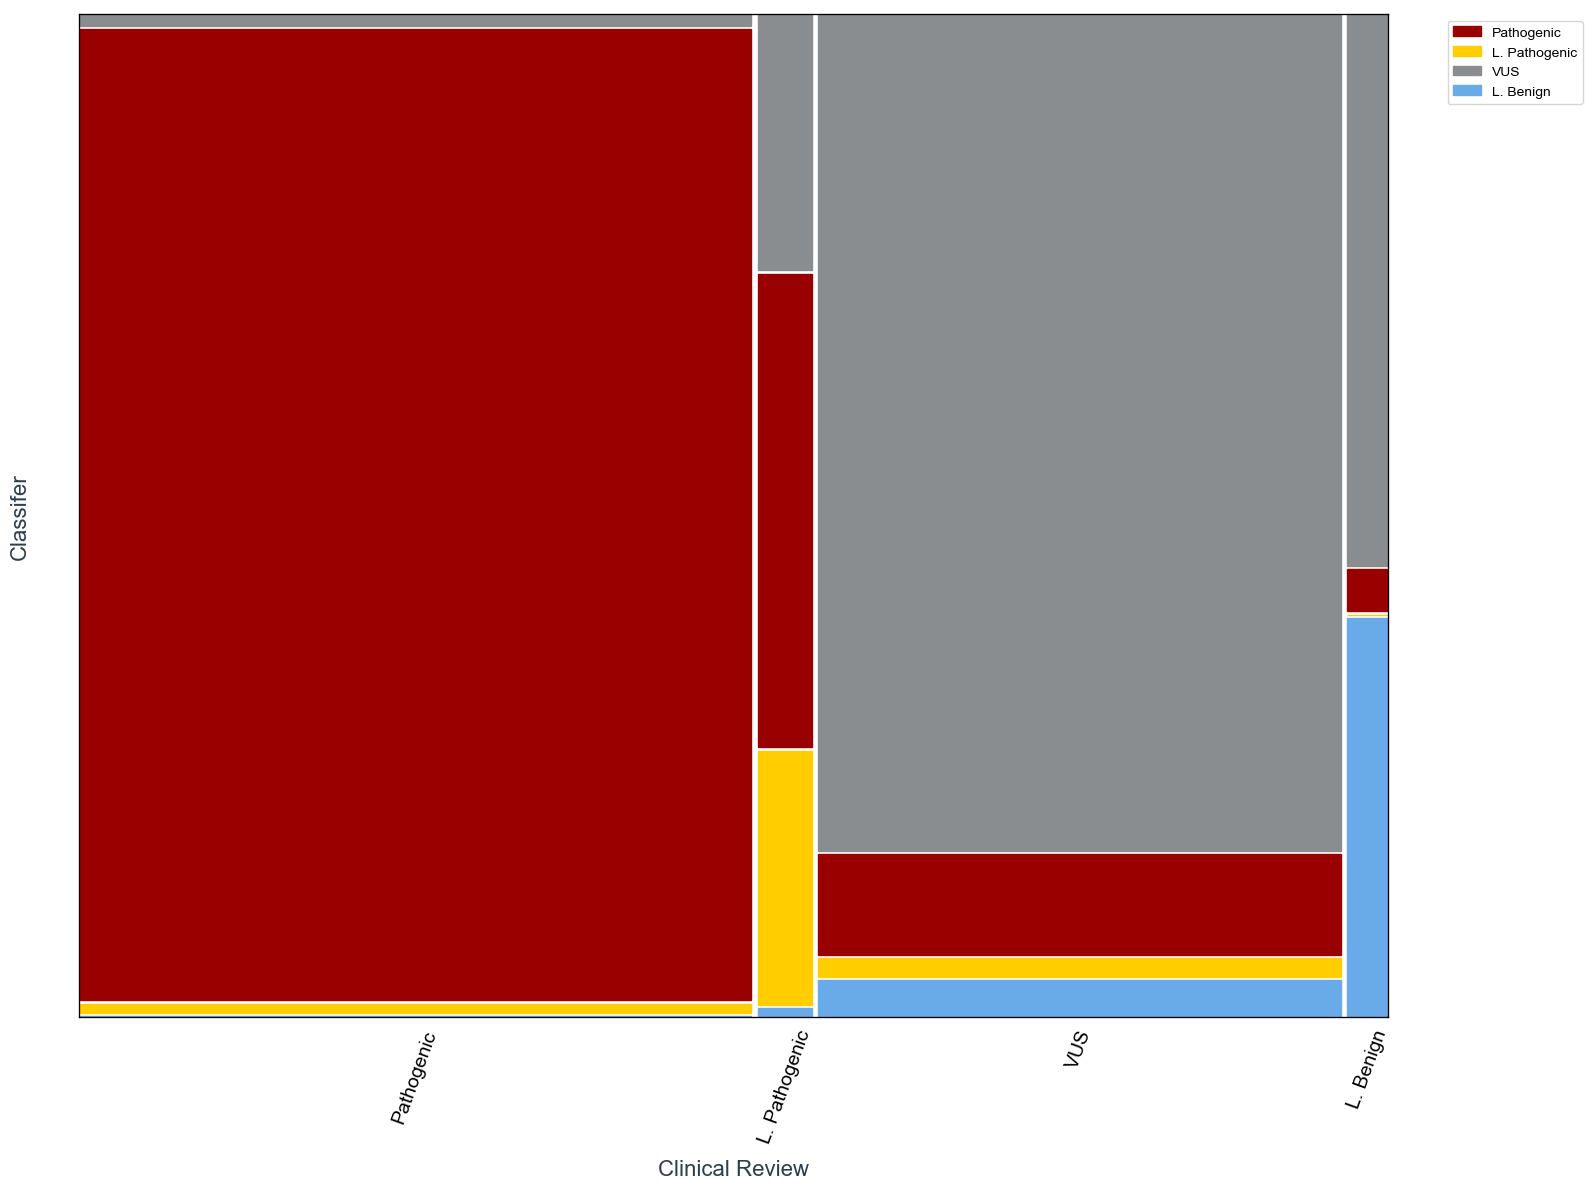

In [30]:
props = {}
# Dictionary introduced here
col_dic = {'Pathogenic': '#990000', 'L. Pathogenic': '#FFCD00', 'VUS': '#8A8D8F', 'L. Benign': '#68ABE8' }
for x in ['Pathogenic', 'L. Pathogenic', 'VUS', 'L. Benign']:
    for y, col in col_dic.items():
        props[(x, y)] ={'color': col}

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(figsize=(16, 12))

font_color = '#2c3e50'

title_font_dict = {
    'fontsize': 20,
    'color' : font_color,
}
axis_label_font_dict = {
    'fontsize': 16,
    'color' : font_color,
}

path_order = ["Pathogenic", "L. Pathogenic", "VUS", "L. Benign"]
gbptdr['CATEGORIZATION'] = pd.Categorical(gbptdr['CATEGORIZATION'],
                                   categories=path_order,
                                   ordered=True)
p = mosaic(data=gbptdr, index=['CATEGORIZATION', 'comp_pred'],properties=props, labelizer=lambda k: '', ax=ax)

ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
ax.axes.yaxis.set_ticks([])
ax.tick_params(axis='x', which='major', labelsize=14, rotation=70)

#ax.set_title('Classification Report', fontdict=title_font_dict, pad=25)
ax.set_xlabel('Clinical Review', fontdict=axis_label_font_dict, labelpad=10)
ax.set_ylabel('Classifer', fontdict=axis_label_font_dict, labelpad=35)

legenditems = [(plt.Rectangle((0,0),1,1, color=col_dic[c]), "%s" %c)
                 for i,c in enumerate(path_order)]
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left",*zip(*legenditems))
plt.tight_layout()
plt.savefig('mosaic_inmodel.pdf',dpi=600)
plt.show()


In [34]:
#grab a list of genes not used in model training
boolean_series = ~gbpr.GENE.isin(gim)
gbponly = gbpr[boolean_series]
gbponly = gbponly[gbponly['CATEGORIZATION'].notna()]

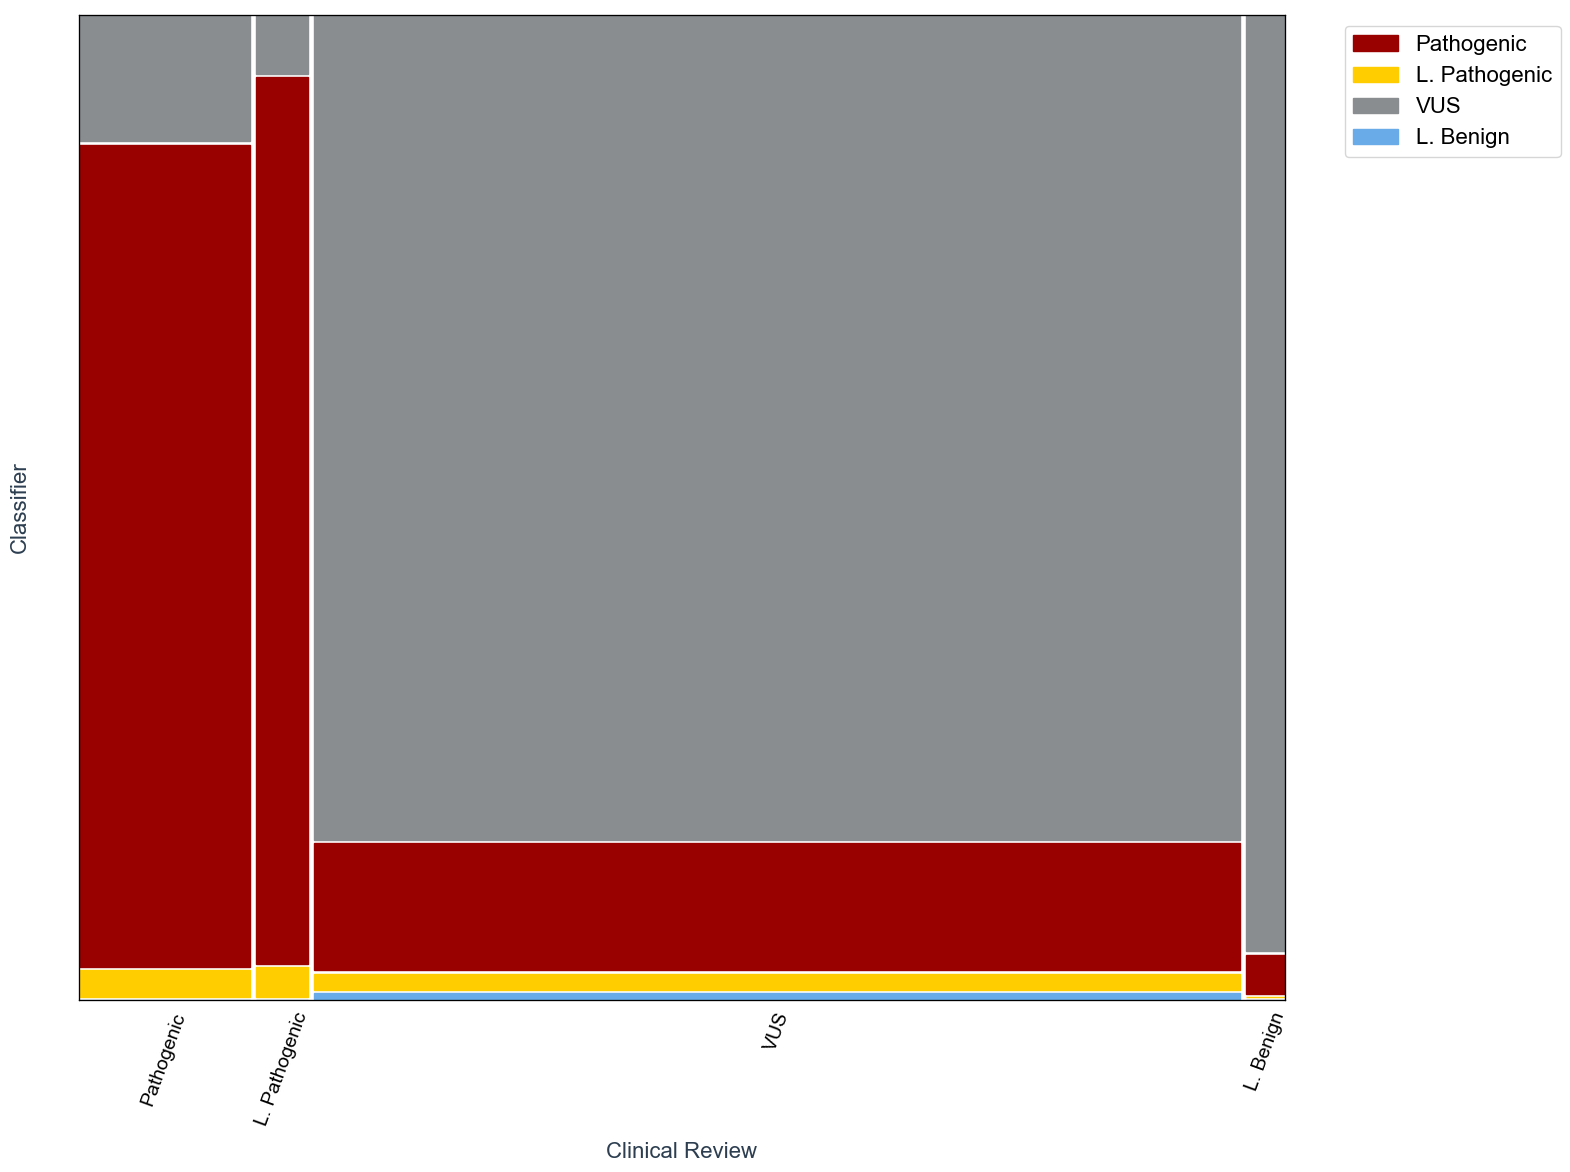

In [38]:
props = {}
# Dictionary introduced here
col_dic = {'Pathogenic': '#990000', 'L. Pathogenic': '#FFCD00', 'VUS': '#8A8D8F', 'L. Benign': '#68ABE8' }


for x in ['Pathogenic', 'L. Pathogenic', 'VUS', 'L. Benign']:
    for y, col in col_dic.items():
        props[(x, y)] ={'color': col}

fig, ax = plt.subplots(figsize=(16, 12))
plt.rcParams.update({'font.size': 16})
font_color = '#2c3e50'

title_font_dict = {
    'fontsize': 20,
    'color' : font_color,
}
axis_label_font_dict = {
    'fontsize': 16,
    'color' : font_color,
}

path_order = ["Pathogenic", "L. Pathogenic", "VUS", "L. Benign"]
gbponly['CATEGORIZATION'] = pd.Categorical(gbponly['CATEGORIZATION'],
                                   categories=path_order,
                                   ordered=True)
p = mosaic(data=gbponly, index=['CATEGORIZATION', 'comp_pred'],properties=props, labelizer=lambda k: '', ax=ax)

ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
ax.axes.yaxis.set_ticks([])
ax.tick_params(axis='x', which='major', labelsize=14, rotation=70)

#ax.set_title('Classification Report', fontdict=title_font_dict, pad=25)
ax.set_xlabel('Clinical Review', fontdict=axis_label_font_dict, labelpad=10)
ax.set_ylabel('Classifier', fontdict=axis_label_font_dict, labelpad=35)

legenditems = [(plt.Rectangle((0,0),1,1, color=col_dic[c]), "%s" %c)
                 for i,c in enumerate(path_order)]
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left",*zip(*legenditems))
plt.tight_layout()
plt.savefig('moscia_outmodel.pdf',dpi=600)
plt.show()